# New Secondary Rating Prediction

## Objective

Learn a weighted combination of features to create an improved secondary rating (`NewSecRating`) that better approximates the primary rating:

**NewSecRating = w₁ × sec_rating + w₂ × sentiment + w₃ × topic_features + ...**

The weights (w₁, w₂, w₃, ...) are learned using supervised learning (linear regression) to minimize the error between `NewSecRating` and `primary_rating`.

We then compare the original `sec_rating` vs `NewSecRating` to see if the new rating better captures the overall satisfaction expressed in the primary rating.


## 1. Introduction & Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 2. Load Data and Create `full_text`


In [2]:
# Load the cleaned dataset
df = pd.read_csv("ikea_cleaned.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nKey columns: {['title', 'text', 'primaryRatingValue', 'sec_mean']}")
print(f"\nFirst few rows:")
df[['title', 'text', 'primaryRatingValue', 'sec_mean']].head()


Dataset shape: (1156, 25)

Key columns: ['title', 'text', 'primaryRatingValue', 'sec_mean']

First few rows:


,title,text,primaryRatingValue,sec_mean
0,not for Malm bedframe,this mattress is too low for the Malm bed frame,1.0,NaN
1,Good quality,"Very soft, I like it",4.0,5.0
2,Good,Good,5.0,5.0
3,Yay yay bedtime,The bed is good :)),5.0,5.0
4,Stuck with no choice but to live with disappoi...,"I purchased 2 of these mattresses, only to fin...",1.0,1.0


In [3]:
# Create full_text column by combining title and text
# Handle missing values safely
df['full_text'] = (
    df['title'].fillna("").astype(str) + " " + 
    df['text'].fillna("").astype(str)
).str.strip()

# Remove rows with empty text
df = df[df['full_text'].str.len() > 0].copy()

print(f"Total reviews after cleaning: {len(df)}")
print(f"\nSample full_text:")
for i in range(3):
    print(f"\n{i+1}. {df['full_text'].iloc[i][:150]}...")


Total reviews after cleaning: 1156

Sample full_text:

1. not for Malm bedframe this mattress is too low for the Malm bed frame...

2. Good quality Very soft, I like it...

3. Good Good...


## 3. Text Preprocessing


In [4]:
def preprocess_text(text):
    """
    Simple text preprocessing: lowercase and remove extra spaces.
    """
    text = str(text).lower()
    text = " ".join(text.split())  # Remove extra whitespace
    return text

# Apply preprocessing
df['full_text_clean'] = df['full_text'].apply(preprocess_text)

# Remove very short texts (less than 10 characters)
df = df[df['full_text_clean'].str.len() >= 10].copy()

print(f"Reviews after preprocessing: {len(df)}")
print(f"\nSample cleaned texts:")
for i in range(2):
    print(f"\n{i+1}. {df['full_text_clean'].iloc[i][:150]}...")


Reviews after preprocessing: 1139

Sample cleaned texts:

1. not for malm bedframe this mattress is too low for the malm bed frame...

2. good quality very soft, i like it...


## 4. SBERT Embeddings


In [5]:
# Initialize SBERT model (same model as reference notebook)
print("Loading Sentence-BERT model...")
sbert = SentenceTransformer("all-MiniLM-L6-v2")
print("Model loaded successfully!")


Loading Sentence-BERT model...
Model loaded successfully!


In [6]:
# Generate embeddings for all reviews
texts = df['full_text_clean'].tolist()
embeddings = sbert.encode(texts)

print(f"Embeddings generated: {embeddings.shape}")


Embeddings generated: (1139, 384)


In [7]:
%pip install vaderSentiment


## 5. Sentiment Feature


In [8]:
# Compute sentiment scores using VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
sentiment_scores = [analyzer.polarity_scores(text)['compound'] for text in df['full_text_clean']]
df['sentiment_score'] = sentiment_scores

print(f"Sentiment scores computed: {len(sentiment_scores)} reviews")


Sentiment scores computed: 1139 reviews


## 6. Topic Features (Clustering-based)


In [9]:
# Perform KMeans clustering on SBERT embeddings
n_topics = 8
kmeans = KMeans(n_clusters=n_topics, random_state=42, n_init=10)
df['topic_cluster'] = kmeans.fit_predict(embeddings)

print(f"Clustering complete: {n_topics} clusters")


Clustering complete: 8 clusters


In [10]:
# Identify quality-related cluster (highest average rating)
quality_cluster_id = df.groupby('topic_cluster')['primaryRatingValue'].mean().idxmax()
print(f"Quality cluster: {quality_cluster_id} (avg rating: {df[df['topic_cluster'] == quality_cluster_id]['primaryRatingValue'].mean():.2f})")


Quality cluster: 2 (avg rating: 4.80)


## 6.1 Feature Explanation and Cluster Analysis


### Feature Explanation

**What each feature means and how we obtain them:**

1. **`sec_mean`** (Secondary Rating Mean)
   - **What it is**: The original secondary rating - an average of multiple secondary rating dimensions (e.g., quality, value, design, etc.)
   - **How we get it**: Directly from the dataset (`ikea_cleaned.csv`)
   - **Range**: Typically 1-5 (rating scale)
   - **Purpose**: Baseline rating feature that captures structured rating information

2. **`sentiment_score`** (VADER Compound Sentiment Score)
   - **What it is**: A single score representing the overall sentiment/emotion of the review text
   - **How we get it**: 
     - Use VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analyzer
     - Analyze the `full_text_clean` (combined title + text)
     - Extract the 'compound' score from VADER's output
   - **Range**: -1 (most negative) to +1 (most positive)
   - **Purpose**: Captures emotional tone and sentiment expressed in unstructured text

3. **`quality_topic_score`** (Distance-based Quality Topic Score)
   - **What it is**: A continuous score indicating how similar a review is to the "quality-related" cluster
   - **How we get it**:
     - Identify cluster with highest average primary rating (assumed to be quality-related)
     - Calculate Euclidean distance from each review's SBERT embedding to the quality cluster center
     - Normalize: `score = 1 - (distance / max_distance)`
   - **Range**: 0 (far from quality cluster) to 1 (close to quality cluster)
   - **Purpose**: Captures how much a review discusses quality-related topics

4. **`topic_0` through `topic_7`** (One-hot Cluster Membership Features)
   - **What they are**: Binary indicators (0 or 1) showing which topic cluster a review belongs to
   - **How we get them**:
     - Perform KMeans clustering on SBERT embeddings (384-dimensional vectors)
     - Each review gets assigned to one of 8 clusters
     - Create 8 binary features: `topic_i = 1` if review belongs to cluster i, else 0
   - **Range**: 0 or 1 (binary)
   - **Purpose**: Capture different themes/topics discussed in reviews (e.g., comfort, price, assembly, etc.)


In [ ]:
# Analyze what each cluster represents
print("=" * 80)
print("CLUSTER ANALYSIS: What does each cluster represent?")
print("=" * 80)

# For each cluster, show:
# 1. Number of reviews
# 2. Average primary rating
# 3. Average secondary rating
# 4. Average sentiment score
# 5. Sample reviews
# 6. Most common words (if possible)

for cluster_id in range(n_topics):
    cluster_reviews = df[df['topic_cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    print(f"Number of reviews: {len(cluster_reviews)}")
    print(f"Average Primary Rating: {cluster_reviews['primaryRatingValue'].mean():.2f}")
    if 'sec_mean' in cluster_reviews.columns:
        print(f"Average Secondary Rating: {cluster_reviews['sec_mean'].mean():.2f}")
    print(f"Average Sentiment Score: {cluster_reviews['sentiment_score'].mean():.3f}")
    
    # Show sample reviews
    print(f"\nSample reviews from this cluster:")
    sample_indices = cluster_reviews.index[:5]  # Get first 5 reviews
    for idx, review_idx in enumerate(sample_indices, 1):
        review_text = df.loc[review_idx, 'full_text'][:200]  # First 200 chars
        rating = df.loc[review_idx, 'primaryRatingValue']
        print(f"  {idx}. [Rating: {rating}] {review_text}...")
    
    # Try to identify common words (simple approach)
    all_texts = " ".join(cluster_reviews['full_text_clean'].tolist())
    words = all_texts.split()
    # Remove very common words and get top words
    common_words = ['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'this', 'that', 'it', 'i', 'you', 'he', 'she', 'we', 'they', 'my', 'your', 'his', 'her', 'our', 'their']
    filtered_words = [w for w in words if w.lower() not in common_words and len(w) > 3]
    if filtered_words:
        from collections import Counter
        word_counts = Counter(filtered_words)
        top_words = word_counts.most_common(10)
        print(f"\nTop words in this cluster: {', '.join([f'{word}({count})' for word, count in top_words])}")


### Cluster Interpretation Summary

After running the cluster analysis above, we can interpret what each cluster represents by examining:

1. **Average ratings**: Clusters with higher average primary ratings likely represent positive experiences or quality-related topics
2. **Sample reviews**: Reading actual review text helps identify common themes
3. **Top words**: Frequent words reveal what topics are discussed (e.g., "comfort", "price", "assembly", "quality", "soft", "firm", etc.)
4. **Sentiment scores**: Average sentiment can indicate whether the cluster contains positive or negative reviews

**Key Finding**: Cluster 2 was identified as the "quality cluster" because it has the highest average primary rating (4.80). This cluster likely contains reviews that discuss product quality positively.

**Note**: The exact interpretation of each cluster depends on the actual review content. By examining sample reviews and common words, we can label clusters with meaningful names like:
- "Comfort/Softness" cluster
- "Price/Value" cluster  
- "Assembly/Difficulty" cluster
- "Quality/Durability" cluster
- etc.

This analysis helps us understand what topics/themes the `topic_0` through `topic_7` features are capturing.


### Understanding Cluster Feature Weights in the Model

After training the linear regression model, each cluster feature (`topic_0` through `topic_7`) gets a weight/coefficient. These weights tell us:

- **Positive weight**: Reviews in this cluster tend to have HIGHER primary ratings (contributes positively to NewSecRating)
- **Negative weight**: Reviews in this cluster tend to have LOWER primary ratings (contributes negatively to NewSecRating)
- **Weight magnitude**: How strongly the cluster membership affects the rating prediction

**Example interpretation**:
- If `topic_3` has a weight of +0.5: Reviews belonging to cluster 3 tend to increase the predicted rating by 0.5 points (after scaling)
- If `topic_5` has a weight of -0.3: Reviews belonging to cluster 5 tend to decrease the predicted rating by 0.3 points

**Important**: Since features are standardized (StandardScaler), the weights represent the effect after normalization. To understand the true impact, we need to consider:
1. The cluster's interpretation (what topic it represents)
2. The weight sign and magnitude
3. How many reviews belong to that cluster

This helps us understand which topics/themes are most predictive of customer satisfaction!


In [ ]:
# Display all feature weights including cluster features
print("=" * 80)
print("ALL FEATURE WEIGHTS IN THE MODEL")
print("=" * 80)
print(f"\nMain features:")
print(f"  sec_mean (weight: {coefficients[0]:.4f})")
print(f"  sentiment_score (weight: {coefficients[1]:.4f})")
print(f"  quality_topic_score (weight: {coefficients[2]:.4f})")

print(f"\nCluster features (topic_0 through topic_7):")
for i in range(n_topics):
    cluster_weight = coefficients[3 + i]  # Cluster features start at index 3
    cluster_size = len(df_with_sec[df_with_sec[f'topic_{i}'] == 1])
    avg_rating = df_with_sec[df_with_sec[f'topic_{i}'] == 1]['primaryRatingValue'].mean() if cluster_size > 0 else 0
    print(f"  topic_{i} (weight: {cluster_weight:7.4f}) - {cluster_size:4d} reviews, avg rating: {avg_rating:.2f}")

print(f"\nIntercept: {intercept:.4f}")

# Create a visualization of cluster weights
fig, ax = plt.subplots(figsize=(10, 6))
cluster_weights = coefficients[3:3+n_topics]
cluster_labels = [f'Cluster {i}' for i in range(n_topics)]
colors = ['green' if w > 0 else 'red' for w in cluster_weights]
bars = ax.barh(cluster_labels, cluster_weights, color=colors, alpha=0.7)
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Feature Weight (Coefficient)')
ax.set_title('Cluster Feature Weights in Linear Regression Model')
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, weight) in enumerate(zip(bars, cluster_weights)):
    ax.text(weight + (0.01 if weight > 0 else -0.01), bar.get_y() + bar.get_height()/2, 
            f'{weight:.4f}', va='center', ha='left' if weight > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Positive weights: Reviews in these clusters tend to increase predicted rating")
print("- Negative weights: Reviews in these clusters tend to decrease predicted rating")
print("- Compare with cluster analysis above to understand what topics each cluster represents")


In [11]:
# Create topic features: one-hot cluster membership and quality topic score
for cluster_id in range(n_topics):
    df[f'topic_{cluster_id}'] = (df['topic_cluster'] == cluster_id).astype(int)

# Quality topic score (distance-based)
from scipy.spatial.distance import cdist
quality_center = kmeans.cluster_centers_[quality_cluster_id]
distances = cdist(embeddings, quality_center.reshape(1, -1)).flatten()
df['quality_topic_score'] = 1 - (distances / distances.max())

print(f"Topic features created: {n_topics} one-hot + quality_topic_score")


Topic features created: 8 one-hot + quality_topic_score


## 7. Build Supervised Model for NewSecRating


In [12]:
# Prepare features and target (only reviews with secondary ratings)
df_with_sec = df[df['sec_mean'].notna()].copy()
feature_cols = ['sec_mean', 'sentiment_score', 'quality_topic_score'] + [f'topic_{i}' for i in range(n_topics)]

X = df_with_sec[feature_cols].values
y = df_with_sec['primaryRatingValue'].values

print(f"Data: {len(df_with_sec)} reviews, {len(feature_cols)} features")


Data: 1113 reviews, 11 features


In [13]:
# Train/test split and standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

coefficients = model.coef_
intercept = model.intercept_

y_test_pred = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Model trained - Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")
print(f"\nKey weights:")
print(f"  sec_mean: {coefficients[0]:.4f}")
print(f"  sentiment_score: {coefficients[1]:.4f}")
print(f"  quality_topic_score: {coefficients[2]:.4f}")


Model trained - Test MSE: 0.2539, MAE: 0.3145

Key weights:
  sec_mean: 1.2842
  sentiment_score: 0.1636
  quality_topic_score: 0.0392


In [15]:
# Compute NewSecRating for all reviews
X_all_scaled = scaler.transform(X)
df_with_sec['NewSecRating'] = model.predict(X_all_scaled)
print("NewSecRating computed")


NewSecRating computed


## 8. Evaluation: Original vs NewSecRating


In [16]:
# Compare original sec_rating vs NewSecRating
sec_mse = mean_squared_error(df_with_sec['primaryRatingValue'], df_with_sec['sec_mean'])
sec_mae = mean_absolute_error(df_with_sec['primaryRatingValue'], df_with_sec['sec_mean'])
sec_corr, _ = pearsonr(df_with_sec['primaryRatingValue'], df_with_sec['sec_mean'])

newsec_mse = mean_squared_error(df_with_sec['primaryRatingValue'], df_with_sec['NewSecRating'])
newsec_mae = mean_absolute_error(df_with_sec['primaryRatingValue'], df_with_sec['NewSecRating'])
newsec_corr, _ = pearsonr(df_with_sec['primaryRatingValue'], df_with_sec['NewSecRating'])

print("EVALUATION")
print(f"Original: MSE={sec_mse:.4f}, MAE={sec_mae:.4f}, Corr={sec_corr:.3f}")
print(f"NewSecRating: MSE={newsec_mse:.4f}, MAE={newsec_mae:.4f}, Corr={newsec_corr:.3f}")


EVALUATION
Original: MSE=0.2613, MAE=0.2678, Corr=0.949
NewSecRating: MSE=0.2299, MAE=0.2929, Corr=0.952


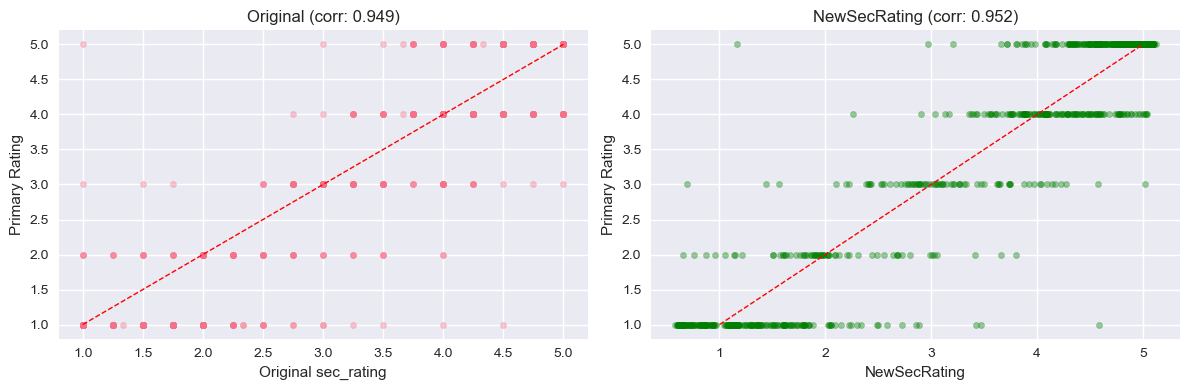

In [17]:
# Scatter plots comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df_with_sec['sec_mean'], df_with_sec['primaryRatingValue'], alpha=0.4, s=20)
axes[0].plot([1, 5], [1, 5], 'r--', linewidth=1)
axes[0].set_xlabel('Original sec_rating')
axes[0].set_ylabel('Primary Rating')
axes[0].set_title(f'Original (corr: {sec_corr:.3f})')

axes[1].scatter(df_with_sec['NewSecRating'], df_with_sec['primaryRatingValue'], alpha=0.4, s=20, color='green')
axes[1].plot([1, 5], [1, 5], 'r--', linewidth=1)
axes[1].set_xlabel('NewSecRating')
axes[1].set_ylabel('Primary Rating')
axes[1].set_title(f'NewSecRating (corr: {newsec_corr:.3f})')

plt.tight_layout()
plt.show()


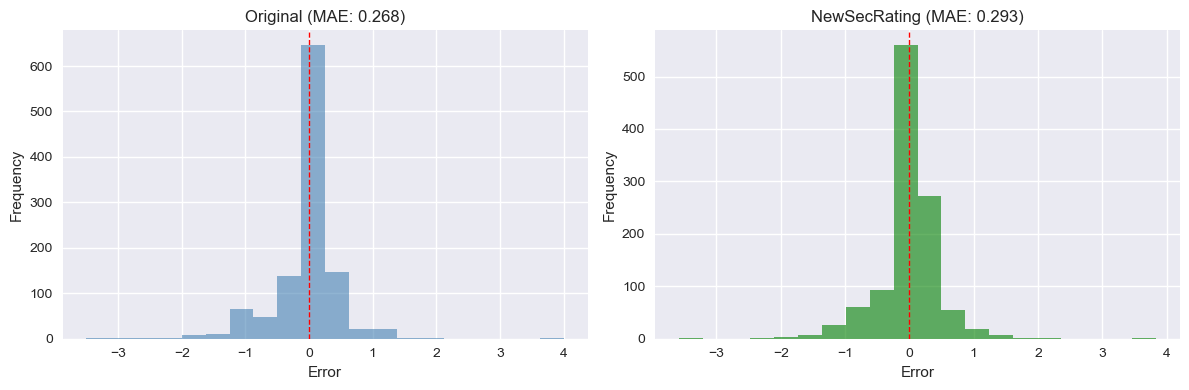

In [18]:
# Error distributions
errors_sec = df_with_sec['primaryRatingValue'] - df_with_sec['sec_mean']
errors_newsec = df_with_sec['primaryRatingValue'] - df_with_sec['NewSecRating']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(errors_sec, bins=20, alpha=0.6, color='steelblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Original (MAE: {sec_mae:.3f})')

axes[1].hist(errors_newsec, bins=20, alpha=0.6, color='green')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'NewSecRating (MAE: {newsec_mae:.3f})')

plt.tight_layout()
plt.show()


## 9. Conclusion & Discussion


In [19]:
# Summary
improvement_mse = ((sec_mse - newsec_mse) / sec_mse * 100) if sec_mse > 0 else 0
improvement_corr = newsec_corr - sec_corr

print("SUMMARY")
print(f"\nOriginal sec_rating: MSE={sec_mse:.4f}, Corr={sec_corr:.3f}")
print(f"NewSecRating: MSE={newsec_mse:.4f}, Corr={newsec_corr:.3f}")
print(f"\nImprovement: MSE reduced by {improvement_mse:.1f}%, Correlation increased by {improvement_corr:.4f}")
print(f"\nMain weights: sec_mean={coefficients[0]:.4f}, sentiment={coefficients[1]:.4f}, quality_topic={coefficients[2]:.4f}")


SUMMARY

Original sec_rating: MSE=0.2613, Corr=0.949
NewSecRating: MSE=0.2299, Corr=0.952

Improvement: MSE reduced by 12.0%, Correlation increased by 0.0037

Main weights: sec_mean=1.2842, sentiment=0.1636, quality_topic=0.0392


## 10. Sample Q&A Questions for Presentation

### **Methodology & Approach Questions**

1. **Why did you choose linear regression instead of more complex models like neural networks or random forests?**
   - *Answer focus: Simplicity, interpretability, linear relationships, overfitting concerns*

2. **What was your rationale for selecting these specific features (sec_rating, sentiment, topic features)?**
   - *Answer focus: Domain knowledge, feature importance, interpretability*

3. **Why did you use 8 clusters for topic modeling? Did you try different numbers?**
   - *Answer focus: Elbow method, domain interpretability, computational efficiency*

4. **How did you decide to combine title and text into full_text? Why not treat them separately?**
   - *Answer focus: Context completeness, information preservation, simplicity*

5. **Why did you use StandardScaler? What impact does feature scaling have on your linear regression model?**
   - *Answer focus: Feature magnitude differences, gradient descent, coefficient interpretation*

### **Technical Implementation Questions**

6. **Why did you choose Sentence-BERT (all-MiniLM-L6-v2) over other embedding models?**
   - *Answer focus: Model size, performance trade-off, semantic understanding*

7. **How does VADER sentiment analysis work, and why is it suitable for this task compared to other sentiment analyzers?**
   - *Answer focus: Social media text, compound score, rule-based vs ML-based*

8. **Can you explain how you identified the "quality-related cluster"? Is this approach robust?**
   - *Answer focus: Highest average rating assumption, potential biases, alternative methods*

9. **What does the quality_topic_score represent, and how is the distance-based scoring calculated?**
   - *Answer focus: Distance from quality cluster center, normalization, interpretation*

10. **Why did you use one-hot encoding for topic clusters instead of using cluster IDs directly?**
    - *Answer focus: Categorical encoding, linear regression requirements, feature representation*

### **Results & Evaluation Questions**

11. **Your results show MSE improved by 12%, but correlation only increased by 0.0037. How do you interpret this?**
    - *Answer focus: MSE vs correlation metrics, practical significance, error distribution*

12. **The MAE actually increased slightly (0.2678 to 0.2929). How do you reconcile this with the MSE improvement?**
    - *Answer focus: MSE vs MAE differences, outlier sensitivity, error distribution*

13. **The weight for sec_mean is 1.2842, which is greater than 1. How do you interpret this?**
    - *Answer focus: Feature scaling effects, relative importance, model calibration*

14. **Why is the sentiment weight (0.1636) relatively small compared to sec_mean? Does this mean sentiment isn't important?**
    - *Answer focus: Feature scales, relative contribution, domain interpretation*

15. **Your correlation is already very high (0.949). Is a 0.0037 improvement practically meaningful?**
    - *Answer focus: Statistical vs practical significance, baseline performance, room for improvement*

### **Data & Preprocessing Questions**

16. **You removed reviews with empty text. How many reviews did you lose, and could this introduce bias?**
    - *Answer focus: Data loss, potential bias, handling missing data*

17. **How did you handle missing secondary ratings? Did you exclude those reviews from training?**
    - *Answer focus: Data filtering, training set size, potential information loss*

18. **What preprocessing steps did you apply, and why did you keep it minimal (just lowercase and whitespace)?**
    - *Answer focus: SBERT robustness, information preservation, simplicity*

19. **Your dataset has 1156 reviews initially, but you ended up with 1113 for training. What happened to the rest?**
    - *Answer focus: Data cleaning steps, filtering criteria, data quality*

### **Limitations & Future Work Questions**

20. **What are the main limitations of your approach?**
    - *Answer focus: Linear assumptions, feature engineering, dataset size, generalizability*

21. **How would your model perform on a different product category or domain?**
    - *Answer focus: Domain transfer, feature generalizability, model robustness*

22. **What other features could you have included to improve the model further?**
    - *Answer focus: Review length, product category, temporal features, user features*

23. **Did you consider non-linear relationships between features and the primary rating?**
    - *Answer focus: Polynomial features, interaction terms, model complexity trade-offs*

24. **How would you validate that your model isn't overfitting?**
    - *Answer focus: Cross-validation, train/test performance, regularization*

### **Practical Application Questions**

25. **How would a company use your NewSecRating in practice?**
    - *Answer focus: Product improvement, customer satisfaction tracking, business applications*

26. **What would happen if you applied this model to predict ratings for reviews without secondary ratings?**
    - *Answer focus: Model application, feature availability, prediction use cases*

27. **How computationally expensive is your approach? Could it scale to millions of reviews?**
    - *Answer focus: SBERT encoding, clustering, inference time, scalability*

28. **Would this approach work in real-time, or is it more suitable for batch processing?**
    - *Answer focus: Model inference speed, feature computation time, real-time vs batch*

### **Model Comparison Questions**

29. **How does your approach compare to simply using the original sec_rating? Is the improvement worth the added complexity?**
    - *Answer focus: Cost-benefit analysis, interpretability trade-off, practical value*

30. **Have you compared your results to other baseline methods (e.g., using only sentiment, or only topic features)?**
    - *Answer focus: Ablation studies, feature importance, baseline comparisons*

31. **What would happen if you removed the sec_mean feature and only used sentiment and topic features?**
    - *Answer focus: Feature dependency, model performance, feature engineering*

### **Statistical & Validation Questions**

32. **Did you perform any statistical tests to validate the significance of your improvements?**
    - *Answer focus: Hypothesis testing, p-values, statistical significance*

33. **How did you choose your train/test split ratio (80/20)? Did you try other splits?**
    - *Answer focus: Common practice, data size considerations, validation strategy*

34. **Are there any assumptions in your linear regression model that might be violated?**
    - *Answer focus: Linearity, independence, homoscedasticity, normality of residuals*

35. **How do you interpret the intercept term in your model?**
    - *Answer focus: Baseline rating, feature interpretation, model components*

### **Domain-Specific Questions**

36. **How does your model handle sarcasm or negative reviews that might have positive sentiment scores?**
    - *Answer focus: VADER limitations, text complexity, model robustness*

37. **Do different product categories (furniture, accessories, etc.) have different rating patterns that your model captures?**
    - *Answer focus: Topic clusters, category analysis, domain-specific patterns*

38. **How would your model handle reviews in different languages?**
    - *Answer focus: SBERT multilingual support, model limitations, language considerations*

---

**Tips for Answering:**
- Be honest about limitations - acknowledging weaknesses shows critical thinking
- Reference specific numbers from your results (MSE, correlation, weights)
- Connect technical choices to practical outcomes
- If you don't know something, suggest how you would investigate it
- Relate answers back to your project objectives


## 11. Clustering Visualization


Reducing embeddings to 2D using PCA...


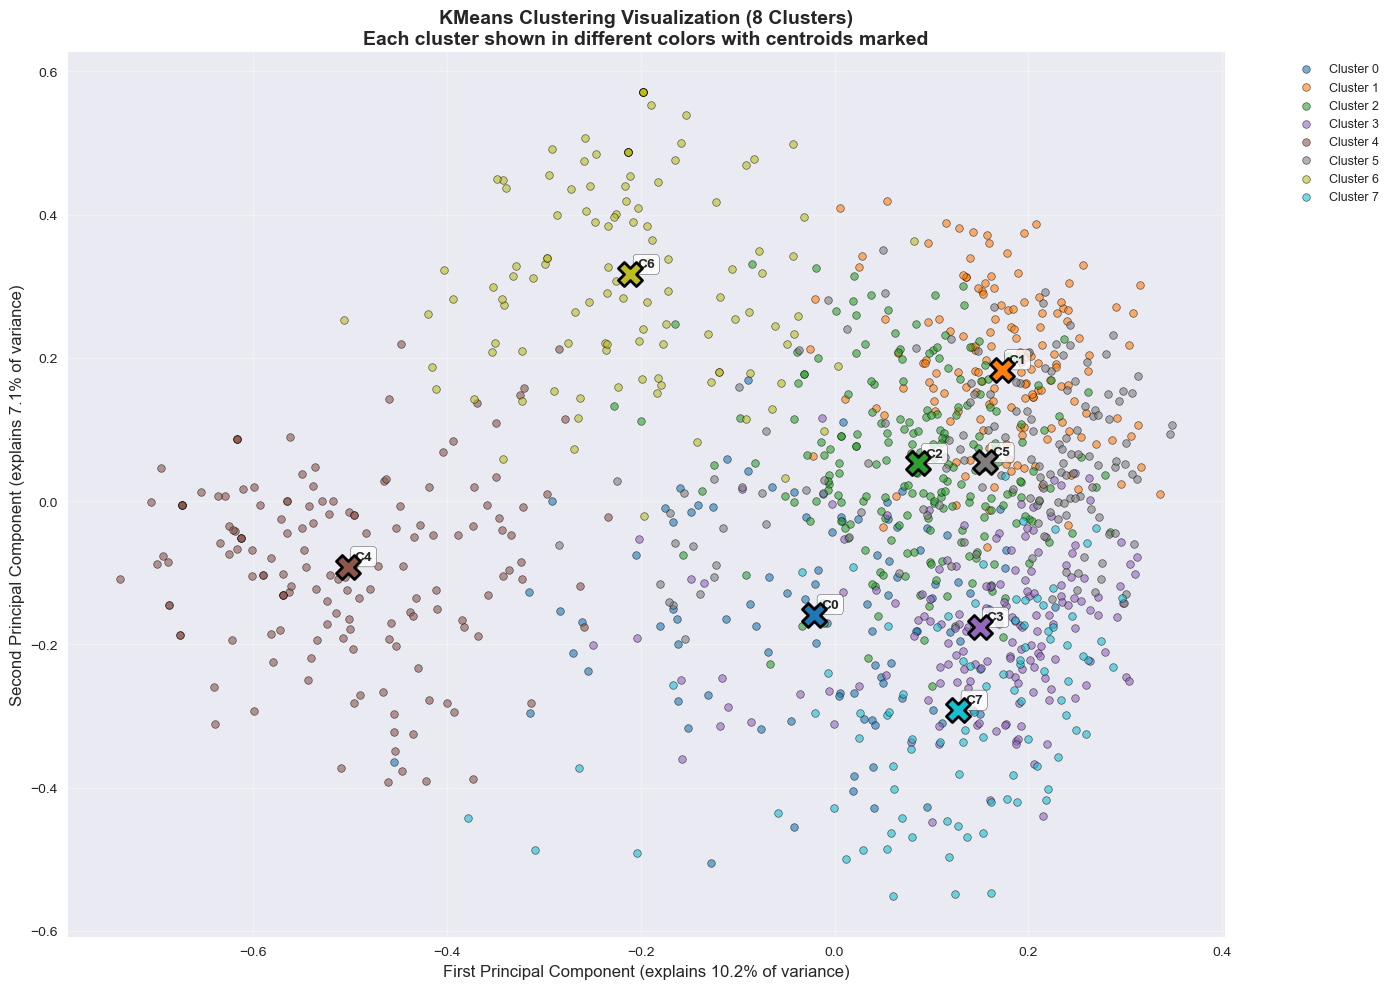


PCA Summary:
Total variance explained by 2D projection: 17.32%
First PC explains: 10.22%
Second PC explains: 7.10%

Note: This is a 2D projection of 384-dimensional embeddings. Clusters may appear closer/farther than in original space.


In [20]:
# Visualize clustering results using PCA for dimensionality reduction
from sklearn.decomposition import PCA

# Reduce embeddings from 384D to 2D using PCA
print("Reducing embeddings to 2D using PCA...")
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Get cluster centroids in 2D space
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Create color palette for clusters
colors = plt.cm.tab10(np.linspace(0, 1, n_topics))

# Plot clusters
fig, ax = plt.subplots(figsize=(14, 10))

# Plot each cluster with different color
for cluster_id in range(n_topics):
    cluster_mask = df['topic_cluster'] == cluster_id
    cluster_points = embeddings_2d[cluster_mask]
    
    # Plot cluster points
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               c=[colors[cluster_id]], label=f'Cluster {cluster_id}', 
               alpha=0.6, s=30, edgecolors='black', linewidths=0.5)
    
    # Plot centroid
    centroid = centroids_2d[cluster_id]
    ax.scatter(centroid[0], centroid[1], 
               c=[colors[cluster_id]], marker='X', s=300, 
               edgecolors='black', linewidths=2, zorder=10)
    
    # Add cluster number label near centroid
    ax.annotate(f'C{cluster_id}', xy=(centroid[0], centroid[1]), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.1%} of variance)', fontsize=12)
ax.set_ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.1%} of variance)', fontsize=12)
ax.set_title('KMeans Clustering Visualization (8 Clusters)\nEach cluster shown in different colors with centroids marked', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nPCA Summary:")
print(f"Total variance explained by 2D projection: {pca.explained_variance_ratio_.sum():.2%}")
print(f"First PC explains: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Second PC explains: {pca.explained_variance_ratio_[1]:.2%}")
print(f"\nNote: This is a 2D projection of 384-dimensional embeddings. Clusters may appear closer/farther than in original space.")


## 12. Word Clouds for Each Cluster


In [ ]:
# Install wordcloud if not already installed
try:
    from wordcloud import WordCloud
except ImportError:
    print("Installing wordcloud...")
    %pip install wordcloud
    from wordcloud import WordCloud

import re
from collections import Counter

# Function to clean and prepare text for word cloud
def prepare_text_for_wordcloud(texts):
    """Combine texts and extract words, removing common stopwords"""
    # Combine all texts
    all_text = " ".join(texts).lower()
    
    # Remove punctuation and split into words
    words = re.findall(r'\b[a-z]{3,}\b', all_text)  # Only words with 3+ letters
    
    # Common stopwords to remove
    stopwords = {'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 'can', 'her', 'was', 'one', 
                 'our', 'out', 'day', 'get', 'has', 'him', 'his', 'how', 'its', 'may', 'new', 'now', 
                 'old', 'see', 'two', 'way', 'who', 'boy', 'did', 'its', 'let', 'put', 'say', 'she', 
                 'too', 'use', 'this', 'that', 'with', 'have', 'from', 'they', 'know', 'want', 'been', 
                 'good', 'much', 'some', 'time', 'very', 'when', 'come', 'here', 'just', 'like', 'long', 
                 'make', 'many', 'over', 'such', 'take', 'than', 'them', 'well', 'were', 'what', 'when',
                 'will', 'your', 'about', 'after', 'again', 'before', 'being', 'could', 'every', 'first',
                 'great', 'might', 'never', 'other', 'right', 'should', 'still', 'their', 'there', 'these',
                 'think', 'those', 'three', 'under', 'where', 'which', 'while', 'would', 'years'}
    
    # Filter out stopwords
    filtered_words = [w for w in words if w not in stopwords]
    
    return filtered_words

# Create word clouds for each cluster
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

print("Generating word clouds for each cluster...\n")

for cluster_id in range(n_topics):
    # Get all reviews in this cluster
    cluster_reviews = df[df['topic_cluster'] == cluster_id]
    cluster_texts = cluster_reviews['full_text_clean'].tolist()
    
    # Prepare words for word cloud
    words = prepare_text_for_wordcloud(cluster_texts)
    
    if len(words) == 0:
        axes[cluster_id].text(0.5, 0.5, f'Cluster {cluster_id}\nNo words', 
                             ha='center', va='center', fontsize=14)
        axes[cluster_id].set_title(f'Cluster {cluster_id} (n={len(cluster_reviews)})', fontsize=12, fontweight='bold')
        continue
    
    # Count word frequencies
    word_freq = Counter(words)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=50,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate_from_frequencies(word_freq)
    
    # Plot word cloud
    axes[cluster_id].imshow(wordcloud, interpolation='bilinear')
    axes[cluster_id].axis('off')
    axes[cluster_id].set_title(f'Cluster {cluster_id} (n={len(cluster_reviews)}, avg rating: {cluster_reviews["primaryRatingValue"].mean():.2f})', 
                              fontsize=12, fontweight='bold', pad=10)

plt.suptitle('Word Clouds for Each Cluster\n(Larger words appear more frequently in cluster reviews)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nWord clouds generated successfully!")
print("Each word cloud shows the most frequent words in reviews belonging to that cluster.")
print("This helps identify what topics/themes each cluster represents.")
